In [1]:
#%reset -f -s
%matplotlib inline
'''------------------------------------------------------------------
MA-eR-PINN: eRange Prediction using Physics-Informed Neural Networks
---------------------------------------------------------------------
Version: V2.0      Modified: 12.01.2025        William Siegle
---------------------------------------------------------------------
PTRAIN - Standard Pipeline Framework for Training the PINN
+ OPTUNA - Hyperparameter Optimization using Optuna
------------------------------------------------------------------''';

In [2]:
# MA-eR-PINN: CONFIGURATION FILE -------------------------------------------------
from pathlib import Path
CONFIG = {
    # SYSTEM: ---------------------------------------------------------------------
    "GPU_SELECT":       0, # {0,1,2,3, None: CPU only}
    "ROOT":             Path('../..').resolve(),
    "INPUT_LOCATION":   Path("TripSequences", "trips_processed_pinn_2"), 
    "OUTPUT_LOCATION":  Path("src", "models", "pth"),
    "SEED"  :           23,
    "PLOT_ACTIVE":      True,

    # DATA PREPROCESSING: ---------------------------------------------------------
    "TRAIN_VAL_TEST":   [0.8, 0.19, 0.01], # [train, val, test splits]
    "MAX_FILES":        None, # None: all files
    "MIN_SEQ_LENGTH":   5400, # minimum sequence length in s to be included in DataSets
    "SCALERS":          {'feature_scaler': 'StandardScaler()','target_scaler': 'StandardScaler()','prior_scaler': 'StandardScaler()'},

    # FEATURES: -------------------------------------------------------------------
    "FEATURES":         ['accelpdlposn_cval','actdrvtrnpwrprc_cval','actualdcvoltage_pti1','actualspeed_pti1','actualtorque_pti1',
                        'airtempinsd_cval_hvac','airtempinsd_rq','airtempoutsd_cval_cpc','altitude_cval_ippc','brc_stat_brc1','brktempra_cval',
                        'bs_brk_cval','currpwr_contendrnbrkresist_cval','elcomp_pwrcons_cval','epto_pwr_cval','hv_bat_dc_momvolt_cval_bms1',
                        'hv_batavcelltemp_cval_bms1','hv_batcurr_cval_bms1','hv_batisores_cval_e2e','hv_batmaxchrgpwrlim_cval_1',
                        'hv_batmaxdischrgpwrlim_cval_1','hv_curr_cval_dcl1','hv_dclink_volt_cval_dcl1','hv_ptc_cabin1_pwr_cval','hv_pwr_cval_dcl1',
                        'lv_convpwr_cval_dcl1','maxrecuppwrprc_cval','maxtracpwrpct_cval','motortemperature_pti1','powerstagetemperature_pti1',
                        'rmsmotorcurrent_pti1','roadgrad_cval_pt','selgr_rq_pt','start_soc','txoiltemp_cval_tcm','vehspd_cval_cpc','vehweight_cval_pt'],                 
    "TARGETS":          ['hv_bat_soc_cval_bms1'],
    "PRIORS":           ['emot_soc_pred'],  

    # MODEL: -----------------------------------------------------------------------
    "HIDDEN_SIZE":      10,    # features in the hidden state h
    "NUM_LAYERS":       3,      # recurrent layers for stacked LSTMs. Default: 1
    "DROPOUT":          0.35,   # usually: [0.2 - 0.5]
    
    # TRAINING & OPTIMIZER: --------------------------------------------------------
    "NUM_EPOCHS":       10,
    "BATCH_SIZE":       32,         # [2, 4, 8, 16, 32, 64, 128, 256]
    "LEARNING_RATE":    1e-2,       # 0.001 lr
    "WEIGHT_DECAY":     1e-2,       # weight decay coefficient (default: 1e-2)
    "MOMENTUM_SGD":     0.0,        # (default: 0.0)
    "OPTIMIZER":        'adamw',    # ('adam', 'sgd', 'adamw')
    "WEIGHT_INIT_TYPE": 'default',  # ('he', 'normal', 'default')
    "CLIP_GRAD":        1.0,        # default: None
    "LRSCHEDULER":      "torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 3, factor = 0.5, min_lr = 1e-7)",  # constant LR for 1.0 as multiplicative factor
                        # torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda _: 1.0)
                        # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience = 3, factor = 0.5, min_lr = 1e-7)

    # LOSS FUNCTION: ---------------------------------------------------------------
    "CRITERION":        "nn.SmoothL1Loss()", # ['nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()', 'MASE()']
    "LOSS_FN":          "F.mse_loss(output, target)", # ['F.mse_loss(output, target)', 'F.l1_loss(output, target)', 'F.smooth_l1_loss(output, target)', 'F.huber_loss(output, target)', 'F.mase_loss(output, target)']
    "P_LOSS_FACTOR":    0.5, # Physics loss factor
}

In [3]:
# OPTUNA: SEARCH SPACE ---------------------------------------------------
global search_space, search_space_NewData
search_space = {
    # MODEL: -----------------------------------------------------------------------
    'HIDDEN_SIZE': ('int', 2, 20, 1),
    'NUM_LAYERS': ('int', 1, 8, 1),
    'DROPOUT': ('float', 0.0, 0.4, 0.05),
    'CLIP_GRAD': ('categorical', (0.01, 0.1, 0.5, 1.0, 1.5, 2.0, 5.0)),
    'WEIGHT_INIT_TYPE': ('categorical', ('he', 'normal', 'default')),

    # TRAINING & OPTIMIZER: --------------------------------------------------------
    'OPTIMIZER': ('categorical', ('adam', 'sgd', 'adamw')),
    'NUM_EPOCHS': ('int', 1, 2, 1),
    'LEARNING_RATE': ('categorical', (1e-5, 5e-5, 1e-4, 3e-4, 5e-4, 8e-4, 1e-3, 3e-3, 5e-3, 8e-3, 1e-2, 2e-2, 5e-2, 1e-1)),
    'WEIGHT_DECAY': ('categorical', (0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2)),
    'MOMENTUM_SGD': ('float', 0.0, 0.9, 0.1),

    # LOSS: --------------------------------------------------------
    'CRITERION': ('categorical', ('nn.MSELoss()', 'nn.L1Loss()', 'nn.SmoothL1Loss()', 'nn.HuberLoss()')),
    'P_LOSS_FACTOR': ('float', 0.05, 1.0, 0.05)
}

search_space_NewData = {
    # DATA PREPROCESSING: ---------------------------------------------------------
    "MIN_SEQ_LENGTH": ('int', 300, 3600, 300),
    'BATCH_SIZE': ('categorical', (4, 8, 16, 32, 64, 128)),
}

N_TRIALS = 3

In [4]:
# LOSS FUNCTION (REPLACE IN OBJECTIVE FUNCTION) ----------------------------------------------------------------   
def loss_fn_PINN_3(output, target, prior):
    l_p = P_LOSS_FACTOR
    y_pred = output; y_true = target; y_phys = prior

    total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
    
    return total_loss

___
SETUP: Locate devices & system folders

In [5]:
# LOCATE REPOSITORY/DATASTORAGE IN CURRENT SYSTEM ENVIRONMENT  ---------------------------
import sys, os
for key in CONFIG: globals()[key] = CONFIG[key]
print(ROOT)
if 'ROOT' not in globals(): ROOT = Path('../..').resolve()
sys.path.append(os.path.abspath(ROOT))

# INTERNAL MODULE IMPORTS ----------------------------------------------------------------
from src.__init__ import *
from src.utils.data_utils import *
from src.utils.preprocess_utils import *
from src.utils.eval_utils import *
from src.utils.Trainers import *
from src.models.lstm_models import *

# SETUP ENVIRONMENT ---------------------------------------------------------------------
DATA_PATH, IS_NOTEBOOK, DEVICE, LOG_FILE_NAME, TS = setup_environment(CONFIG, ROOT, SEED, GPU_SELECT)

if not IS_NOTEBOOK or True:
    output_file = open(f"{LOG_FILE_NAME}", "w")
    sys.stdout = Tee(sys.stdout, output_file); sys.stderr = Tee(sys.stderr, output_file)

/home/sieglew/MA-eR-PINN
------------------------------------------------------------
Directories:
  /home/sieglew/MA-eR-PINN:			test, .git, archive, project, data, src
  /mnt/nvme/datasets/sieglew:			TripSequences
------------------------------------------------------------
Running in notebook mode
CONFIG Dictionary:
---------------------------------------------------------------------------------------------------------------------------------
     Parameter         Value
--  ----------------  ---------------------------------------------------------------------------------------------------------------
0   GPU_SELECT        0
1   ROOT              /home/sieglew/MA-eR-PINN
2   INPUT_LOCATION    TripSequences/trips_processed_pinn_2
3   OUTPUT_LOCATION   src/models/pth
4   SEED              23
5   PLOT_ACTIVE       True
6   TRAIN_VAL_TEST    [0.8, 0.19, 0.01]
7   MAX_FILES         None
8   MIN_SEQ_LENGTH    5400
9   SCALERS           {'feature_scaler': 'StandardScaler()', 'target_scale

___
DATA SELECTION & PREPROCESSING

In [6]:
# FILE SOURCES ---------------------------------------------------------------
input_folder = Path(DATA_PATH, INPUT_LOCATION) # Trip parquet files
pth_folder = Path(ROOT, OUTPUT_LOCATION, f"{TS}")
files, trip_lengths, indices_by_length, sorted_trip_lengths, all_signals = prepare_data(input_folder, pth_folder, MAX_FILES, MIN_SEQ_LENGTH, ROOT)

------------------------------------------------------------
Total Files:	16116
Filtered Files:	2536
------------------------------------------------------------
               FileName  Length  Index
0       V13_T25.parquet   20843   1478
1      V18_T775.parquet   19425   1930
2      V13_T352.parquet   18308   1383
3      V18_T972.parquet   17858   2011
4     V16_T1629.parquet   17519   1750
...                 ...     ...    ...
2531   V13_T286.parquet    5408   1675
2532   V12_T852.parquet    5407   1722
2533   V13_T114.parquet    5407   2397
2534   V13_T736.parquet    5406   2276
2535   V14_T952.parquet    5401   2505

[2536 rows x 3 columns]
------------------------------------------------------------
Input Signals:	37
Target Signals:	1
Physical Prior Signals:	1
------------------------------------------------------------
 --> Warning: Removed the last 13 samples to ensure a balanced batch size
fitting Scalers: StandardScaler, StandardScaler, StandardScaler
	50% of the fitting don

In [7]:
# INPUT & TARGET SPECIFICATION ---------------------------------------------------
# these signals are required for the physical Model calculation:
base_signals = ["signal_time", "hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 
                "hv_batpwr_cval_bms1", "emot_pwr_cval","bs_roadincln_cval", "roadgrad_cval_pt"]

# these signals have to be dropped (from Features) in order for appropriate training:
columns_to_drop = ["signal_time",                       # works as index
                    "hirestotalvehdist_cval_icuc",      # starts from 0, obtained by speed integration
                    "latitude_cval_ippc",               # only GPS 
                    "longitude_cval_ippc",              # only GPS
                    "hv_batpwr_cval_bms1",              # directly related to target (soc_gradient)
                    "hv_batmomavldischrgen_cval_1",     # indirect target 1 in kWh
                    "hv_bat_soc_cval_bms1",              # indirect target 2 in %SoC
                    "soc_gradient",                     # actual target signal   
                    "emot_pwr_cval",                    # replaced as physical prior for PINN
                    "emot_pwr_pred",                    # actual physical prior for PINN
                    ]

# Ensure no element of "columns_to_drop" is included in "FEATURES"
assert not any(col in FEATURES for col in columns_to_drop), "Some columns to drop are still in FEATURES"

# ---------------------------------------------------
selection_1 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", 'roadgrad_cval_pt', "vehweight_cval_pt", "accelpdlposn_cval", "bs_brk_cval", "elcomp_pwrcons_cval",
               "epto_pwr_cval", "motortemperature_pti1", "powerstagetemperature_pti1", 'airtempinsd_cval_hvac', 'brktempra_cval', 'selgr_rq_pt']
selection_2 = ["hirestotalvehdist_cval_icuc", "vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "hv_batpwr_cval_bms1", "emot_pwr_cval", "roadgrad_cval_pt"]
selection_3 = ["vehspd_cval_cpc", "altitude_cval_ippc", "airtempoutsd_cval_cpc", "vehweight_cval_pt"]

In [8]:
# FEATURE SELECTION  ----------------------------------------------------------------------------
INPUT_COLUMNS = FEATURES; TARGET_COLUMN = TARGETS; PRIOR_COLUMN = PRIORS
print(f"{'-'*60}\nInput Signals:\t{len(FEATURES)}\nTarget Signals:\t{len(TARGETS)}\nPhysical Prior Signals:\t{len(PRIORS)}\n{'-'*60}")

# FEATURE NORMALIZATION/SCALING -----------------------------------------------------------------
scaler = eval(SCALERS['feature_scaler'])
target_scaler = eval(SCALERS['target_scaler'])
prior_scaler = eval(SCALERS['prior_scaler'])

In [9]:
# DATA SET SPLITTING AND SORTING ----------------------------------------------------------------
train_subset, val_subset, test_subset = random_split(files, TRAIN_VAL_TEST)

# DATALOADER SETTINGS ------------------------------------------------------------------
dataloader_settings = {'batch_size': 1, 'shuffle': True, 'collate_fn': collate_fn_PINN, 'num_workers': 8,
 'prefetch_factor': 4, 'persistent_workers': True, 'pin_memory': False if DEVICE.type == 'cpu' else True}

# PREPARE TRAIN, VAL & TEST DATALOADERS  ------------------------------------------------------------
train_subset, train_dataset, train_dataset_batches, train_loader = prepare_dataloader_PINN(train_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, fit=True, drop_last=True)

val_subset, val_dataset, val_dataset_batches, val_loader = prepare_dataloader_PINN(val_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=True)

test_subset, test_dataset, test_dataset_batches, test_loader = prepare_dataloader_PINN(test_subset, indices_by_length, \
    BATCH_SIZE, INPUT_COLUMNS, TARGET_COLUMN, PRIOR_COLUMN, scaler, target_scaler, prior_scaler, dataloader_settings, drop_last=False)

# print dataset info
subset_files = print_dataset_sizes(train_dataset, val_dataset, test_dataset, train_subset, val_subset, test_subset, files)

In [10]:
# Load dataloaders
#train_loader = torch.load('train_loader.pth')
#val_loader = torch.load('val_loader.pth')
#test_loader = torch.load('test_loader.pth')

In [11]:
if IS_NOTEBOOK and False: 
    check_batch_PINN(train_loader)
    visualize_padding(BATCH_SIZE, trip_lengths, sorted_trip_lengths, train_loader, val_loader, test_loader)

___
MODEL & TRAINING CONFIGURATIONS

In [12]:
# LSTM NETWORK -----------------------------------------------------------------------

class LSTM1_packed_old_version(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, device=DEVICE):
        super(LSTM1_packed_old_version, self).__init__()

        self.input_size = input_size    # input size
        self.hidden_size = hidden_size  # hidden state
        self.num_layers = num_layers    # number of layers
        self.dropout = dropout

        # LSTM CELL --------------------------------
        self.lstm = nn.LSTM(self.input_size,self.hidden_size,self.num_layers,batch_first=True,dropout=self.dropout,device=device)

        # LAYERS -----------------------------------
        self.dropout_layer = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn1 = nn.BatchNorm1d(hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, 1)
        self.relu = nn.ReLU()

    def forward(self, packed_input, batch_size=None):
        packed_out, _ = self.lstm(packed_input)
        out, _ = pad_packed_sequence(packed_out, batch_first=True)
        out = self.relu(out)  # relu
        out = self.dropout_layer(out)  # dropout
        out = self.fc1(out)  # fully connected layer 1
        out = self.bn1(out.transpose(1, 2)).transpose(1, 2)
        out = self.relu(out)  # relu
        out = self.fc2(out)  # fully connected layer 2
        return out

    # Define the weight initialization function for LSTM
    def initialize_weights_lstm(self, init_type):
        for name, param in self.named_parameters():
            if 'weight_ih' in name or 'weight_hh' in name:
                if init_type == 'he': nn.init.kaiming_uniform_(param.data, nonlinearity='relu')     # HE INIT
                elif init_type == 'normal': nn.init.normal_(param.data, mean=0.0, std=0.02)         # NORMAL INIT
                elif init_type == 'default': continue                                               # TORCH DEFAULT INIT
            elif 'bias' in name and init_type != 'default': nn.init.constant_(param.data, 0)

___
TRAINING

___
OPTUNA: Hyperparameter Optimization

[I 2025-01-15 09:50:46,155] A new study created in memory with name: no-name-20f9ee48-73f5-4aa0-b4ec-974ccb0ad7ec


Trial 0
------------------------------------------------------------
Training Started.	Process ID: 2160316 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	63 / 63
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7fee2dd179c0>
Optimizer:		SGD
LR:			1e-05
Weight Decay:		0.0
------------------------------------------------------------
------------------------------------------------------------
Training Completed.	Execution Time: 00:02:15
------------------------------------------------------------



Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/63 [00:00<?, ?batch/s]

  0%|          | 0/63 [00:00<?, ?batch/s]

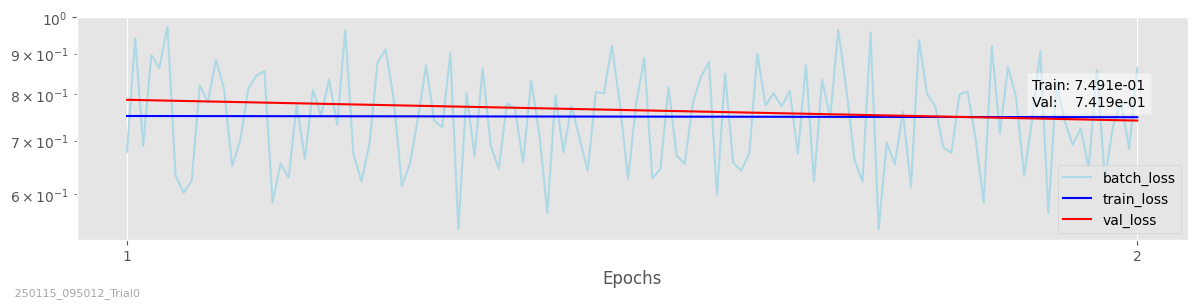

[I 2025-01-15 09:53:02,208] Trial 0 finished with value: 0.7418834805488587 and parameters: {'HIDDEN_SIZE': 2, 'NUM_LAYERS': 6, 'DROPOUT': 0.35000000000000003, 'CLIP_GRAD': 5.0, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'sgd', 'NUM_EPOCHS': 2, 'LEARNING_RATE': 1e-05, 'WEIGHT_DECAY': 0.0, 'MOMENTUM_SGD': 0.9, 'CRITERION': 'nn.MSELoss()', 'P_LOSS_FACTOR': 0.1}. Best is trial 0 with value: 0.7418834805488587.


Trial 1
------------------------------------------------------------
Training Started.	Process ID: 2160316 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	63 / 63
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7feffa0d77e0>
Optimizer:		SGD
LR:			1e-05
Weight Decay:		0.0
------------------------------------------------------------
------------------------------------------------------------
Training Completed.	Execution Time: 00:02:32
------------------------------------------------------------



Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/63 [00:00<?, ?batch/s]

  0%|          | 0/63 [00:00<?, ?batch/s]

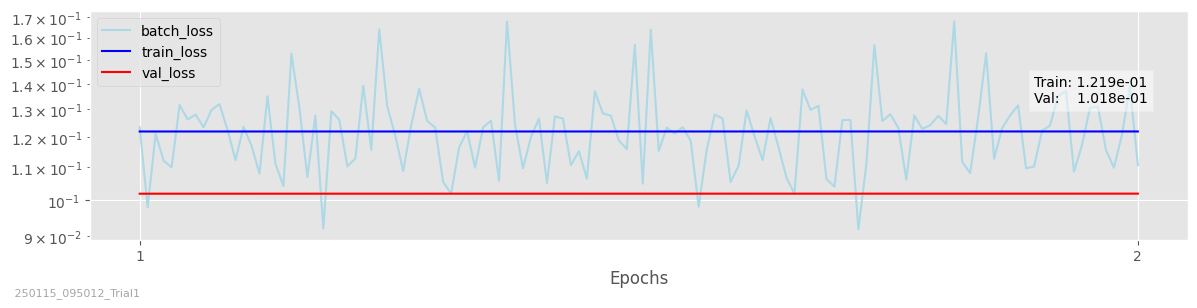

[I 2025-01-15 09:55:34,920] Trial 1 finished with value: 0.10182312528292338 and parameters: {'HIDDEN_SIZE': 2, 'NUM_LAYERS': 7, 'DROPOUT': 0.35000000000000003, 'CLIP_GRAD': 1.0, 'WEIGHT_INIT_TYPE': 'default', 'OPTIMIZER': 'sgd', 'NUM_EPOCHS': 2, 'LEARNING_RATE': 1e-05, 'WEIGHT_DECAY': 0.0, 'MOMENTUM_SGD': 0.30000000000000004, 'CRITERION': 'nn.HuberLoss()', 'P_LOSS_FACTOR': 0.7000000000000001}. Best is trial 1 with value: 0.10182312528292338.


Trial 2
------------------------------------------------------------
Training Started.	Process ID: 2160316 
------------------------------------------------------------
Model: LSTM1_packed_old_version	Parameters on device: CUDA:0
------------------------------------------------------------
Train/Batch size:	63 / 63
Loss:			<function objective.<locals>.loss_fn_PINN_3 at 0x7feff549b380>
Optimizer:		AdamW
LR:			0.0001
Weight Decay:		0.001
------------------------------------------------------------
------------------------------------------------------------
Training Completed.	Execution Time: 00:01:30
------------------------------------------------------------



Epoch,Iteration,Batch Loss,Train Loss


  0%|          | 0/63 [00:00<?, ?batch/s]

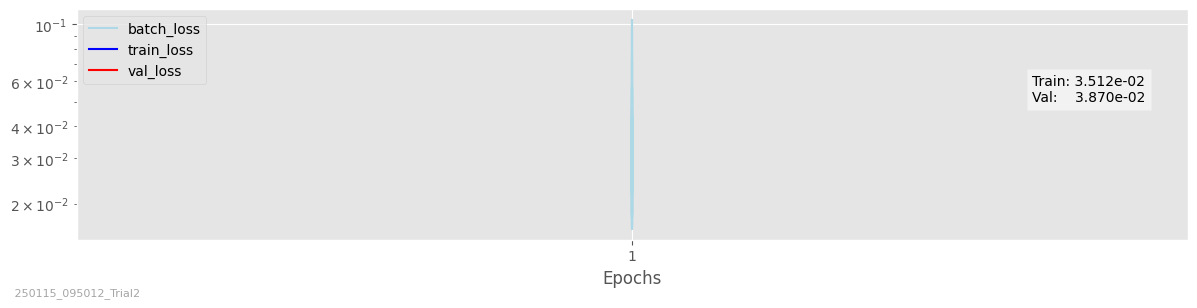

[I 2025-01-15 09:57:04,909] Trial 2 finished with value: 0.03869647501657406 and parameters: {'HIDDEN_SIZE': 5, 'NUM_LAYERS': 8, 'DROPOUT': 0.2, 'CLIP_GRAD': 1.0, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adamw', 'NUM_EPOCHS': 1, 'LEARNING_RATE': 0.0001, 'WEIGHT_DECAY': 0.001, 'MOMENTUM_SGD': 0.0, 'CRITERION': 'nn.L1Loss()', 'P_LOSS_FACTOR': 0.9500000000000001}. Best is trial 2 with value: 0.03869647501657406.


In [13]:
# OPTUNA: OBJECTIVE ---------------------------------------------------
def objective(trial):

    # OPTUNA: CREATE TRIAL OBJECTS ---------------------------------------------------
    optuna_params = {}
    for param, (suggest_type, *args) in search_space.items():
        if suggest_type == 'int': optuna_params[param.lower()] = trial.suggest_int(param, *args[:2], step=args[2])
        elif suggest_type == 'float': optuna_params[param.lower()] = trial.suggest_float(param, *args[:2], step=args[2])
        elif suggest_type == 'categorical': optuna_params[param.lower()] = trial.suggest_categorical(param, *args)
    
    # Update CONFIG with suggested hyperparameters
    for param in optuna_params.keys(): CONFIG[param.upper()] = optuna_params[param]
    for key in CONFIG: globals()[key] = CONFIG[key]
    # -----------------------------------------------------------------------------------

    # TRAINING_CODE: -----------------------------------------------------------------
    # INSTANTIATE MODEL AND APPLY WEIGHT INITIALIZATION --------------------
    model = LSTM1_packed_old_version(len(INPUT_COLUMNS), HIDDEN_SIZE, NUM_LAYERS, DROPOUT).to(DEVICE)
    model.initialize_weights_lstm(WEIGHT_INIT_TYPE)
    
    if OPTIMIZER=='adam': optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    elif OPTIMIZER=='adamw': optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, weight_decay = WEIGHT_DECAY)
    elif OPTIMIZER=='sgd': optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM_SGD, weight_decay=WEIGHT_DECAY)

    scheduler = eval(LRSCHEDULER); criterion = eval(CRITERION)

    # LOSS FUNCTION ----------------------------------------------------------------   
    def loss_fn_PINN_3(output, target, prior):
        l_p = P_LOSS_FACTOR
        y_pred = output; y_true = target; y_phys = prior
        total_loss = F.mse_loss(y_true, (l_p * y_phys + (1 - l_p) * y_pred), reduction='mean')
        return total_loss

    # TRAIN -----------------------------------------------------------------
    TRAINER = PTrainer_PINN(model = model, optimizer = optimizer, scheduler = scheduler,
     loss_fn = loss_fn_PINN_3, train_loader = train_loader, val_loader = val_loader, test_loader = test_loader, num_epochs = NUM_EPOCHS, device = DEVICE, is_notebook = IS_NOTEBOOK, 
     use_mixed_precision = True, log_file = Path(LOG_FILE_NAME).with_name(f"{TS}_Trial{trial.number}.txt"))

    print(f"Trial {trial.number}")
    RESULTS = TRAINER.train_model()
    plot_training_performance(RESULTS)

    # RETURN latest val_loss ---------------------------------------------------------
    val_loss = RESULTS['val_losses'][-1]

    return val_loss


# OPTUNA: STUDY -------------------------------------------------------------------
study = optuna.create_study(direction='minimize', sampler = optuna.samplers.TPESampler())    # TPESampler, RandomSampler, GridSampler, CmaEsSampler, NSGAIISampler
study.optimize(objective, n_trials=N_TRIALS)


___
SAVE CHECKPOINT

In [14]:
# Save the best trial config to a text file
print("Best hyperparameters: ", study.best_params)
best_trial = study.best_trial
best_trial_dict = {
    'params': best_trial.params,
    'value': best_trial.value}
with open(Path(LOG_FILE_NAME).with_name(f"{TS}_BEST_TRIAL.txt"), 'w') as f: json.dump(best_trial_dict, f, indent=4)

Best hyperparameters:  {'HIDDEN_SIZE': 5, 'NUM_LAYERS': 8, 'DROPOUT': 0.2, 'CLIP_GRAD': 1.0, 'WEIGHT_INIT_TYPE': 'he', 'OPTIMIZER': 'adamw', 'NUM_EPOCHS': 1, 'LEARNING_RATE': 0.0001, 'WEIGHT_DECAY': 0.001, 'MOMENTUM_SGD': 0.0, 'CRITERION': 'nn.L1Loss()', 'P_LOSS_FACTOR': 0.9500000000000001}
